# Misspecification on Hodgkin-Huxley model: tutorial

In this tutorial, we will check model misspecification on a [Hodgkin-Huxley
model](https://en.wikipedia.org/wiki/Hodgkin%E2%80%93Huxley_model) from
neuroscience (Hodgkin and Huxley, 1952). 



Note, you find a tutorial on the HH model in the `sbi` repository under
[docs/tutorials/Example_00_HodgkinHuxleyModel.ipynb](https://github.com/sbi-dev/sbi/blob/main/docs/tutorials/Example_00_HodgkinHuxleyModel.ipynb).

Here we assume, that you are already familiar with the Hodgkin-Huxley model and the basic functionality of `sbi`.


First we are going to import basic packages.


In [56]:
%load_ext autoreload
%autoreload 2

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import torch

# HH simulator
from HH_helper_functions import HHsimulator, calculate_summary_statistics, syn_current

from sbi import analysis as analysis

# sbi
from sbi import utils as utils
from sbi.inference import NPE, simulate_for_sbi
from sbi.neural_nets import posterior_nn
from sbi.neural_nets.embedding_nets import FCEmbedding
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# remove top and right axis from plots
mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False

## 1. Observed data

Let us assume we current-clamped a neuron and recorded the following voltage trace:

<img src="https://raw.githubusercontent.com/mackelab/delfi/master/docs/docs/tutorials/observed_voltage_trace.png" width="480">
<br>


## 2. Simulator

We would like to infer the posterior over the two parameters ($\color{orange}{\bar g_{Na}}$,$\color{orange}{\bar g_K}$) of a Hodgkin-Huxley model, given the observed electrophysiological recording above. The model has channel kinetics as in [Pospischil et al. 2008](https://link.springer.com/article/10.1007/s00422-008-0263-8), and is defined by the following set of differential equations (parameters of interest highlighted in orange):


$$
\scriptsize
\begin{align}
\color{black}{C_m\frac{dV}{dt}}& \color{black}{=g_1\left(E_1-V\right)}+
                    \color{orange}{\bar{g}_{Na}} \color{black}{m^3h\left(E_{Na}-V\right)+}
                    \color{orange}{\bar{g}_{K}} \color{black}{n^4\left(E_K-V\right)+\bar{g}_Mp\left(E_K-V\right)+I_{inj}+\sigma\eta\left(t\right)}\\
                    \color{black}{\frac{dq}{dt}}&\color{black}{=\frac{q_\infty\left(V\right)-q}{\tau_q\left(V\right)},\;q\in\{m,h,n,p\}}
\end{align}
$$


In [3]:
# current, onset time of stimulation, offset time of stimulation, time step, time, area of some
I_inj, t_on, t_off, dt, t, A_soma = syn_current()

In [4]:
def run_HH_model(params):

    params = np.asarray(params)

    # input current, time step
    I_inj, t_on, t_off, dt, t, A_soma = syn_current()

    t = np.arange(0, len(I_inj), 1) * dt

    # initial voltage V0
    initial_voltage = -70

    voltage_trace = HHsimulator(initial_voltage, params.reshape(1, -1), dt, t, I_inj)

    return dict(data=voltage_trace.reshape(-1), time=t, dt=dt, I_inj=I_inj.reshape(-1))

And for convenience we define the simulator to return only the voltage trace:

In [60]:
def simulator(params):
    """
    Returns only voltage trace
    """
    obs = run_HH_model(params)
    return torch.tensor(obs["data"], dtype=torch.float).reshape(1, -1)

To get an idea of the output of the Hodgkin-Huxley model, let us generate some voltage traces for different parameters ($\bar g_{Na}$,$\bar g_K$), given the input current $I_{\text{inj}}$:


In [61]:
# three sets of (g_Na, g_K)
params = np.array([[10.0, 5.0], [4.0, 1.5], [20.0, 10.0]])

num_samples = len(params[:, 0])
sim_samples = np.zeros((num_samples, len(I_inj)))
for i in range(num_samples):
    sim_samples[i, :] = run_HH_model(params=params[i, :])["data"]

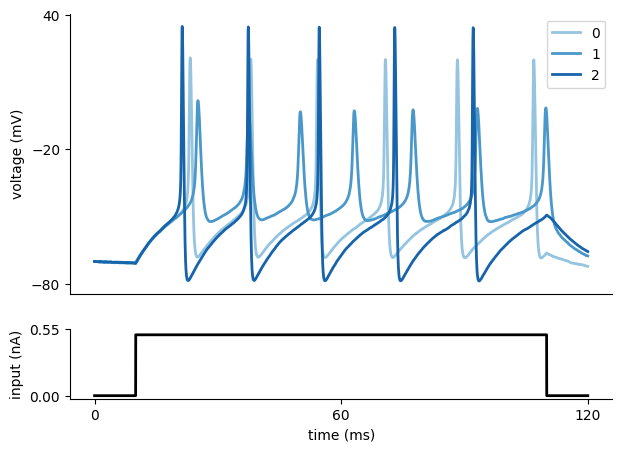

In [62]:
# colors for traces
col_min = 2
num_colors = num_samples + col_min
cm1 = mpl.cm.Blues
col1 = [cm1(1.0 * i / num_colors) for i in range(col_min, num_colors)]

fig = plt.figure(figsize=(7, 5))
gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[4, 1])
ax = plt.subplot(gs[0])
# plot the three voltage traces for different parameter sets
for i in range(num_samples):
    plt.plot(t, sim_samples[i, :], color=col1[i], lw=2, label=i)
plt.legend()

plt.ylabel("voltage (mV)")
ax.set_xticks([])
ax.set_yticks([-80, -20, 40])

# plot the injected current
ax = plt.subplot(gs[1])
plt.plot(t, I_inj * A_soma * 1e3, "k", lw=2)
plt.xlabel("time (ms)")
plt.ylabel("input (nA)")

ax.set_xticks([0, max(t) / 2, max(t)])
ax.set_yticks([0, 1.1 * np.max(I_inj * A_soma * 1e3)])
ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%.2f"))
plt.show()

## 3. Prior over model parameters

Now that we have the simulator, we need to define a function with the prior over the model parameters ($\bar g_{Na}$,$\bar g_K$), which in this case is chosen to be a Uniform distribution:


> Note: This is where you would incorporate prior knowlegde about the parameters you want to infer, e.g., ranges known from literature. 


In [63]:
# well specified prior:
# prior_min = [0.5, 1e-4] # g_Na, g_K
# prior_max = [80.0, 15.0]

# misspecified prior:
prior_min = [0.5, 1e-4]
prior_max = [40.0, 5]
prior = utils.torchutils.BoxUniform(
    low=torch.as_tensor(prior_min), high=torch.as_tensor(prior_max)
)

In [64]:
# Generate training data

theta_train, x_train = simulate_for_sbi(
    simulator, proposal=prior, num_simulations=500, num_workers=4
)

100%|██████████| 500/500 [00:43<00:00, 11.40it/s]


In [65]:
# Generate misspecified sample
params_mis = np.array([70, 15])
x_o_mis = torch.tensor(
    run_HH_model(params=params_mis)["data"], dtype=torch.float
).reshape(1, -1)

# and well specified
params_o = np.array([10, 4])
x_o = torch.tensor(run_HH_model(params=params_o)["data"], dtype=torch.float).reshape(
    1, -1
)

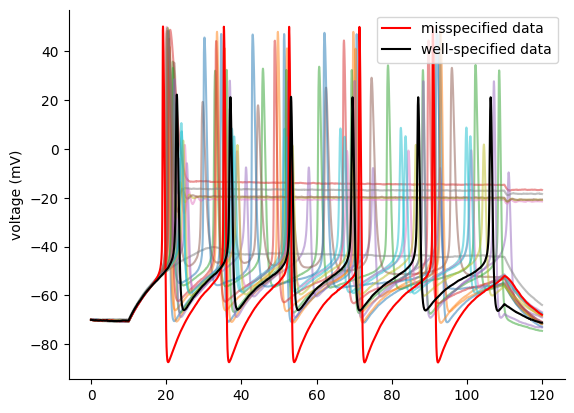

In [66]:
plt.plot(t, x_train[:20, :].T, alpha=0.5)
plt.ylabel("voltage (mV)")
ax.set_xticks([])
ax.set_yticks([-80, -20, 40])
plt.plot(t, x_o_mis[0], color="red", label="misspecified data")
plt.plot(t, x_o[0], color="black", label="well-specified data")
plt.legend()

plt.show()

### a) Misspecification on raw data

In [67]:
from sbi.diagnostics.misspecification import calc_misspecification_mmd

Let's first check the well specified observation `x_o`:

In [68]:
p_val, (mmds_baseline, mmd) = calc_misspecification_mmd(
    inference=None,
    x_obs=x_o,
    x=x_train,
    n_shuffle=1_000,
    max_samples=1_000,
)

print(f"p-value: {p_val}")

p-value: 0.774


Now let's check the misspecified observation `x_o_mis`:

In [69]:
p_val_mis, (_, mmd_mis) = calc_misspecification_mmd(
    inference=None,
    x_obs=x_o_mis,
    x=x_train,
    n_shuffle=1_000,
    max_samples=1_000,
)

print(f"p-value: {p_val_mis}")

p-value: 0.0


This indicates that the observed value `x_o_mis` is very unlikely under the null hypothesis, which states that that the observation is coming from the true data distribution $p(x)$.

We can therefore reject $H_0$ and have evidence that `x_o_mis` is coming from a different distribution. 

### b) Misspecification based on summary statistics

Now, as many neuroscientists work on summary statistics for the Hodgking Huxley model, let's do the same analysis on the preprocessed data.

Let's first define an augmented simulator which returns the summary statistics directly:

In [32]:
def simulator_sumstats(params):
    """
    Returns summary statistics from conductance values in `params`.

    Summarizes the output of the HH simulator and converts it to `torch.Tensor`.
    """
    obs = run_HH_model(params)
    summstats = torch.as_tensor(calculate_summary_statistics(obs))
    return summstats


# Check prior, simulator, consistency
prior, num_parameters, prior_returns_numpy = process_prior(prior)
simulator_sumstats = process_simulator(simulator_sumstats, prior, prior_returns_numpy)
check_sbi_inputs(simulator_sumstats, prior)

In [ ]:
# Generate training data
theta_train_sumstats, x_train_sumstats = simulate_for_sbi(
    simulator_sumstats, proposal=prior, num_simulations=500, num_workers=4
)

100%|██████████| 500/500 [00:43<00:00, 11.49it/s]


In [35]:
# Generate misspecified sample
params_mis = np.array([70, 15])
x_raw = run_HH_model(params=params_mis)
x_o_mis_sumstats = torch.as_tensor(
    calculate_summary_statistics(x_raw), dtype=torch.float
).reshape(1, -1)


# and well specified
params_o = np.array([10, 4])
x_raw = run_HH_model(params=params_o)
x_o_sumstats = torch.as_tensor(
    calculate_summary_statistics(x_raw), dtype=torch.float
).reshape(1, -1)

Let's again first look at the well specified observation:

In [36]:
p_val, (mmds_baseline, mmd) = calc_misspecification_mmd(
    inference=None,
    x_obs=x_o_sumstats,
    x=x_train_sumstats,
    n_shuffle=1_000,
    max_samples=1_000,
)

print(f"p-value: {p_val}")

p-value: 0.624


All good here...

Now the misspecified observation:

In [37]:
p_val_mis, (mmds_baseline, mmd) = calc_misspecification_mmd(
    inference=None,
    x_obs=x_o_mis_sumstats,
    x=x_train_sumstats,
    n_shuffle=1_000,
    max_samples=1_000,
)

print(f"p-value: {p_val_mis}")

p-value: 0.126


Interestingly, we can not reject $H_0$ in this case, although visually the traces look quite different. 
This is potentially due to the choice of summary statistics together with the fact that we only have tested one single observation `x_o_mis`.

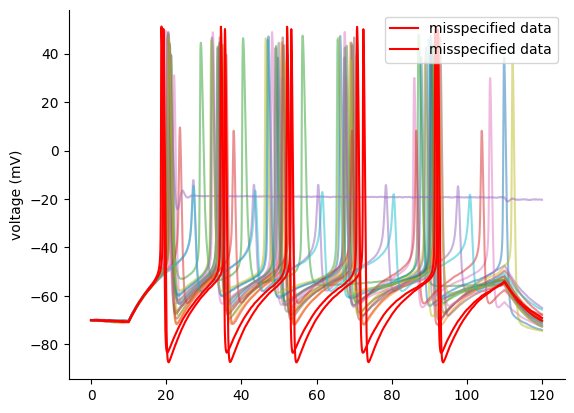

In [48]:
# Generate misspecified sample
params_mis = np.array([[70, 15], [78, 10]])
x_raw = []
x_o_mis_sumstats = []
for i in range(len(params_mis)):
    x_raw.append(run_HH_model(params=params_mis[i]))
    x_o_mis_sumstats.append(calculate_summary_statistics(x_raw[i]))

x_o_mis_sumstats = torch.as_tensor(
    np.array(x_o_mis_sumstats), dtype=torch.float
).reshape(-1, 7)

plt.plot(t, x_train[:20, :].T, alpha=0.5)
plt.ylabel("voltage (mV)")
ax.set_xticks([])
ax.set_yticks([-80, -20, 40])
for i in range(len(params_mis)):
    plt.plot(t, np.array(x_raw[i]["data"]), color="red", label="misspecified data")

plt.legend()

plt.show()

In [ ]:
p_val_mis, (mmds_baseline, mmd) = calc_misspecification_mmd(
    inference=None,
    x_obs=x_o_mis_sumstats,
    x=x_train_sumstats,
    n_shuffle=10_000,
)

print(f"p-value: {p_val_mis}")

p-value: 0.008099999999999996


### c) Misspecification in the embedding space

Instead of using handcrafted summary statistics we can also use an embedding net $e$ and investigate if the embedded data $z=e(x)$ is misspecified.
For this we first have to run inference, to train the embedding net. 
In this toy example we will use a fully connected net to reduce the dimensionality of the voltage traces. 

We will use the same training data as in a).

In [83]:
# train NPE networks
emb_net = FCEmbedding(
    input_dim=x_train.shape[1], output_dim=20, num_layers=4, num_hiddens=50
)  # minimal embedding network
neural_posterior = posterior_nn(model="maf", embedding_net=emb_net)
inference = NPE(prior=prior, density_estimator=neural_posterior)
inference = inference.append_simulations(theta_train, x_train)
density_estimator = inference.train()
posterior = inference.build_posterior(density_estimator)

 Neural network successfully converged after 79 epochs.

In [84]:
samples = posterior.sample((10000,), x=x_o)

Drawing 10000 posterior samples: 10466it [00:00, 182045.68it/s]           


/var/folders/kx/9z7xgc9916l5ztl7kgxlydkm0000gn/T/ipykernel_14403/3436400821.py:1: DeprecationWarning: you passed deprecated arguments **kwargs: ['points_offdiag', 'points_colors'], use fig_kwargs instead. We continue calling the deprecated pairplot function
  fig, axes = analysis.pairplot(


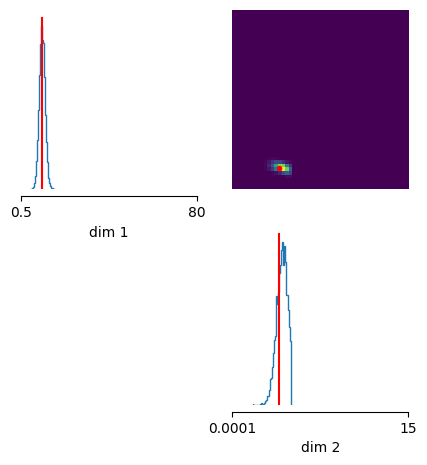

In [ ]:
fig, axes = analysis.pairplot(
    samples,
    limits=[[0.5, 80], [1e-4, 15.0]],
    ticks=[[0.5, 80], [1e-4, 15.0]],
    figsize=(5, 5),
    points=params_o,
    points_offdiag={"markersize": 6},
    points_colors="r",
    # labels=labels_params,
)

In [ ]:
# perform two tests for misspecification
# 1. well specified model
p_val_well, _ = calc_misspecification_mmd(
    inference=inference,
    x_obs=x_o,
    x=x_train,
    mode="embedding",
)
print(f"p-value well specified: {p_val_well}")

# 2. misspecified model
p_val_mis, (mmds_baseline, mmd) = calc_misspecification_mmd(
    inference=inference,
    x_obs=x_o_mis,
    x=x_train,
    mode="embedding",
)
print(f"p-value misspecified: {p_val_mis}")

p-value well specified: 0.876
p-value misspecified: 0.0


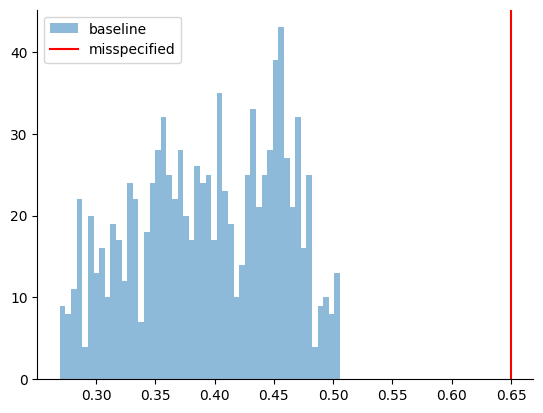

In [77]:
plt.hist(mmds_baseline, bins=50, alpha=0.5, label="baseline")
plt.axvline(mmd, color="red", label="misspecified")
plt.legend()
plt.show()